# Анализ сервиса аренды самокатов GoFast 

# Описание проекта

GoFast - популярный сервис аренды самокатов. 
Сервисом можно пользоваться либо с подпиской Ultra, либо без подписки.

Продакт-менеджеры хотят увеличить количество пользователей с подпиской. 
Наша задача - провести исследовательский анализ и проверить ряд гипотез:

1. Тратят ли пользователи с подпиской больше времени на поездки?
2. Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
3. Превышает ли помесячная выручка от пользователей с подпиской выручку от пользователей без подписки.

# План работы:
1. [Загрузка данных](#load_data)
2. [Предобработка данных](#preprocessing)
3. [Исследовательский анализ данных](#analysis)
4. [Объединение данных](#merge)
5. [Подсчет выручки](#revenue)
6. [Проверка гипотез](#hypotheses)
7. [Общие выводы](#conclusions)

# Описание данных

Для проведения анализа нам предоставлены три csv-файла с информацией о пользователях, их поездках и подписках.

Информация о пользователях хранится в файле `users_go.csv`

- `user_id` - уникальный идентификатор пользователя
- `name` - имя пользователя
- `age` - возраст
- `city` - 	город
- `subscription_type` - тип подписки (free, ultra)

Информация о поездках хранится в файле `rides_go.csv`

- `user_id` - уникальный идентификатор пользователя
- `distance` - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- `duration` - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- `date` - дата совершения поездки

Информация о подписках хранится в файле `subscriptions_go.csv`

- `subscription_type` - тип подписки
- `minute_price` - стоимость одной минуты поездки по данной подписке
- `start_ride_price` - стоимость начала поездки
- `subscription_fee` - стоимость ежемесячного платежа

<a id="load_data"></a>
# Загрузка данных

Импортируем библиотеки и установим цветовую палитру по умолчанию

In [2]:
from math import factorial
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats as st
#from decimal import Decimal

In [3]:
sns.set_theme(style="whitegrid", palette="pastel")

Загрузим данные из файлов и проанализируем общую информацию о них.

In [4]:
try:
    users = pd.read_csv('D:/Работа, курсы, обучение+книги/Курсы, самообучение/!DA Plus Yandex/9th sprint/Проект/users_go.csv')
except:
    users = pd.read_csv('/datasets/users_go.csv')
    
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [5]:
users.sample(5)

,user_id,name,age,city,subscription_type
1395,1396,Георгий,24,Краснодар,free
506,507,Эвелина,27,Пятигорск,ultra
822,823,Евгения,21,Ростов-на-Дону,free
363,364,Зарина,25,Тюмень,ultra
1313,1314,Злата,26,Пятигорск,free


In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


По предварительной оценке пропуски в данных в таблице с информацией о пользователях отсутствуют, типы данных соответствуют сути содержащейся информации.

In [7]:
try:
    rides = pd.read_csv('D:/Работа, курсы, обучение+книги/Курсы, самообучение/!DA Plus Yandex/9th sprint/Проект/rides_go.csv')
except:
    rides = pd.read_csv('/datasets/rides_go.csv')
    
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [8]:
rides.sample(5)

,user_id,distance,duration,date
14436,1275,3031.533445,20.126134,2021-01-22
3986,430,3078.720379,12.104739,2021-07-07
16548,1425,4074.302012,14.866217,2021-10-06
2533,268,2532.578492,12.235939,2021-10-04
681,75,3625.144090,21.083814,2021-11-13


In [9]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Пропущенные значения в данных с поездками также отсутствуют, однако в столбце date тип данных следует привести к типу, отвечающему за дату.

In [10]:
try:
    subcriptions = pd.read_csv('D:/Работа, курсы, обучение+книги/Курсы, самообучение/!DA Plus Yandex/9th sprint/Проект/subscriptions_go.csv')
except:
    subcriptions = pd.read_csv('/datasets/subscriptions_go.csv')
    
subcriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [11]:
subcriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


В предоставленных данных присутствуют только 2 вида подписок:

free: стоимость одной минуты - 8 рублей, стоимость старта - 50 рублей, абонплата 0 рублей. <br>
ultra: стоимость одной минуты - 6 рублей, стоимость старта - 0 рублей, абонплата 199 рублей.

Данные в таблице о подписках соответствуют данным, обозначенным нам со стороны заказчика.

<b> Вывод по загрузке данных

Предварительно пропуски в данных отсутствуют. 
Таблица с информацией о пользователях содержит чуть более 1,5 тыс. строк.
В таблице с поездками число строк составляет около 18 тыс. 
В данных могут иметься дубликаты (что по сути подтверждает выгрузка первых 5 строк таблицы с поездками, которые относятся к одному пользователю). Проверку на дубликаты мы проведем на следующем этапе (предобработка данных).
Кроме того, в таблице с информацией о поездках тип данных в столбце date необходимо привести к формату datetime.

<a id="preprocessing"></a>
# Предобработка данных

In [12]:
# приведем столбец date к типу даты pandas
rides['date'] = pd.to_datetime(rides['date'])

In [13]:
# посмотрим каким временным промужетком представлены данные в таблице rides:
print(f'Минимальная дата в таблице rides - {rides.date.min()}, максимальная дата - {rides.date.max()}')

Минимальная дата в таблице rides - 2021-01-01 00:00:00, максимальная дата - 2021-12-30 00:00:00


In [14]:
# создадим новый столбец с номером месяца
rides['month'] = rides['date'].dt.month

In [15]:
# проверим число полных дубликатов в таблице users
print(f'Количество полных дубликатов в таблице users - {users.duplicated().sum()}')

Количество полных дубликатов в таблице users - 31


In [16]:
# создадим переменную для сопоставления числа удаленных строк к первоначальной таблице в рамках исключения дубликатов
users_before = users.shape[0]

In [17]:
# удалим полные дубликаты из таблицы users
users.drop_duplicates(keep='first', inplace=True)

In [18]:
print(f'Число удаленных дубликатов составило {1 - users.shape[0] / users_before:.2%} первоначальных данных.')

Число удаленных дубликатов составило 1.98% первоначальных данных.


In [19]:
# проверим число дубликатов по user_id  в таблице users (в остальных столбцах могут быть дубликаты, учитывая их суть)
print('Количество дубликатов по user_id -', users.duplicated(subset='user_id').sum())

Количество дубликатов по user_id - 0


Проверим датафрейм rides на наличие дубликатов.
Один пользователь может совершать несколько поездок в один и тот же день.
Однако вероятность того, что один и тот же пользователь в один и тот же день совершил поездки на одинаковое расстояние и время маловероятны.
Поэтому сочтем такие строки за дубликаты.

In [20]:
# проверим количество полных дубликатов в датафрейме rides
print('Количество полных дубликатов в таблице rides -', rides.duplicated().sum())

Количество полных дубликатов в таблице rides - 0


Дубликаты в таблице subcriptions отсутствуют. Чему свидетельствует сама таблица, выведенная нами в предыдущем разделе:

<a id="analysis"></a>
# Исследовательский анализ данных

Для начала посмотрим на уникальные категории и число значений в рамках данных категорий в разрезе столбцов таблицы users

In [22]:
for column in users.columns:
    display(users[column].value_counts().head(10))

1       1
1020    1
1029    1
1028    1
1027    1
1026    1
1025    1
1024    1
1023    1
1022    1
Name: user_id, dtype: int64

Анна         22
Мария        22
Александр    17
Дмитрий      17
Никита       16
Иван         15
Кира         15
Ксения       14
Регина       13
Вячеслав     13
Name: name, dtype: int64

25    145
24    132
26    131
23    129
27    119
22    119
28    112
21     93
20     71
30     68
Name: age, dtype: int64

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

free     835
ultra    699
Name: subscription_type, dtype: int64

По данным таблицы users основная категория пользователей это лица 20 лет (от 20 до 30).

Перейдем к анализу таблицы rides и посмотрим периодичность использования самокатов пользователями.

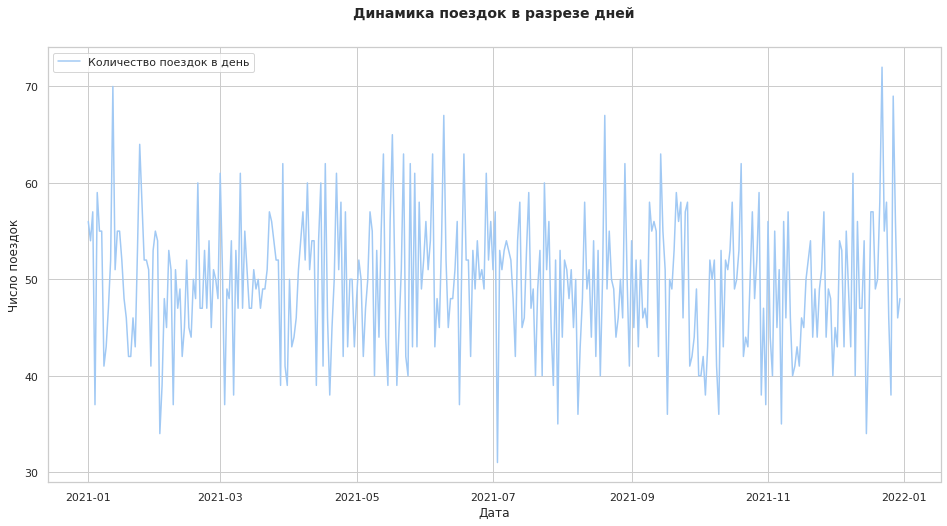

In [23]:
# Создание фигуры с заданным размером
fig = plt.subplots(figsize=(16, 8))

# Группировка данных по дате и подсчет числа поездок в разрезе дат
rides_dated = rides.groupby('date')['user_id'].count()

# Построение линейного графика количества поездок в день
sns.lineplot(x=rides_dated.index, y=rides_dated)

# Добавление заголовка с заданными параметрами шрифта
plt.title('Динамика поездок в разрезе дней', fontsize=14, fontweight='bold', pad=30)

# Добавление названия осей и легенды
plt.xlabel('Дата')
plt.ylabel('Число поездок')
plt.legend(['Количество поездок в день'])

# Отображение графика
plt.show()

Данные представлены за 2021 год.
С учетом специфики использования самокатов, а также присутствии в списке топ-городов северных городов РФ, потенциально должна быть просадка в использовании самокатов в зимний период.
Однако такой динамики на графике мы не наблюдает.
Необходимо будет провести доп. анализ данных.

Учитывая выявленные нюансы выше и запрос на оценку частоты встречаемости городов в рамках аренды самокатов в сервисе посмотрим на распределение данных по городам.

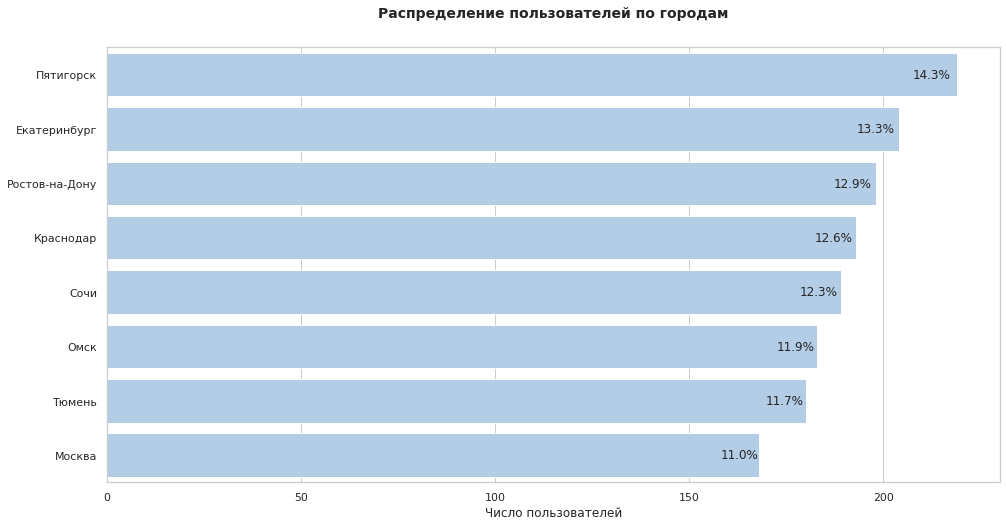

In [24]:
# Создаем фигуру и оси для графика
fig, ax = plt.subplots(figsize=(16, 8))

# Получаем данные о количестве пользователей в каждом городе
users_city = users['city'].value_counts()

# Стоим горизонтальную столбчатую диаграмму
sns.barplot(x=users_city, y=users_city.index, color = '#abcdef', ax=ax)

# добавим подписи долей в процентах
for i, val in enumerate(users_city.values / users_city.sum()):
    ax.text(users_city.values[i]*0.97, i, f'{round(val*100, 1)}%', 
                         horizontalalignment='center', 
                         verticalalignment='center', 
                         fontdict={'fontweight':500, 'size': 12})

# Устанавливаем название графика и осей
plt.xlabel('Число пользователей')
plt.title('Распределение пользователей по городам', fontsize=14, fontweight='bold', pad=30)

# Отображаем график
plt.show()

Наибольшее число пользователей приходится на Пятигорск.
Наименьшее - на Москву.
В целом разброс пользователей по городам умеренный.

<b> Оценим соотношение числа пользователей с подпиской и без.

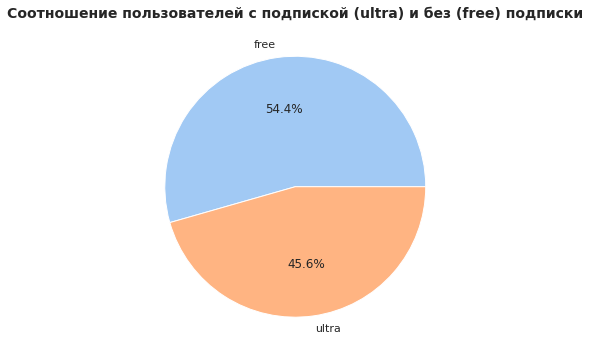

Общее число пользователей - 1534


In [25]:
# Получим данные о пользователях с подпиской (ultra) и без (free)
users_subtype = users['subscription_type'].value_counts().reset_index()
    
# Создаем круговую диаграмму с заданным размером
plt.figure(figsize=(10, 6)) 
plt.pie(
    users_subtype['subscription_type'], 
    labels=users_subtype['index'],  
    autopct='%1.1f%%' 
    )

# Зададим заголовок круговой диаграммы
plt.title('Соотношение пользователей с подпиской (ultra) и без (free) подписки', fontsize=14, fontweight="bold")

# Отобразим диаграмму
plt.show()

# Дополнительно отобразим общее число пользователей
print(f'Общее число пользователей - {users.shape[0]}')

Число пользователей без подписки незначительно превышает число пользователей с подпиской.

<b> По предварительной оценке наибольшее число пользователей это лица от 20 до 30 лет. <br>
Посмотрим на распределение возраста пользователей внимательнее.

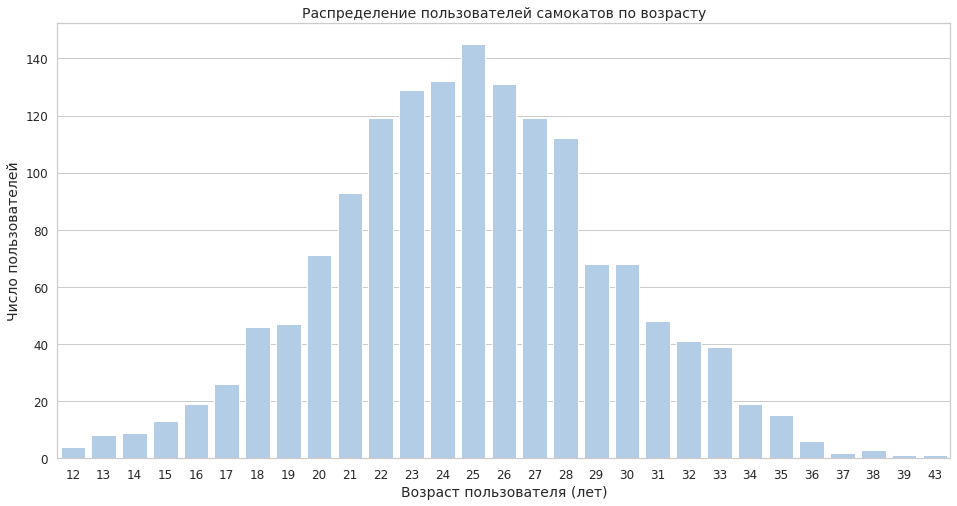

In [26]:
# Создаем стобчатую диаграмму с заданным размером
fig = plt.subplots(figsize=(16, 8))

# столбчатая диаграмма (countplot) возраста пользователей
sns.countplot(data=users, x='age', color = '#abcdef')

# Зададим подписи осей и легенды
plt.tick_params(labelsize=12)
plt.title("Распределение пользователей самокатов по возрасту", fontsize=14)
plt.ylabel('Число пользователей', fontsize=14)
plt.xlabel('Возраст пользователя (лет)', fontsize=14)

# Отобразим график
plt.show()

Text(0.5, 0, 'Возраст пользователя (лет)')

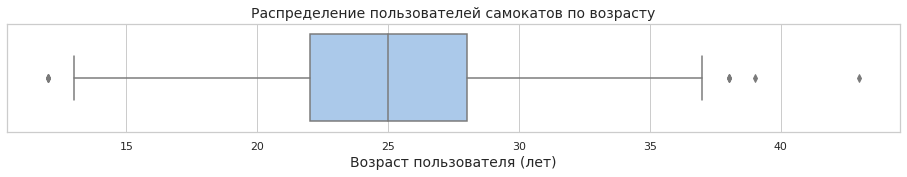

In [27]:
# Создаем boxplot с заданным размером
fig = plt.subplots(figsize=(16, 2))

# boxplot возраста пользователей
sns.boxplot(data=users, x='age', orient='h')

plt.title('Распределение пользователей самокатов по возрасту', fontsize=14)
plt.xlabel('Возраст пользователя (лет)', fontsize=14)

Данные графика подтверждают ранее сделанные наблюдения. В целом, распределение возраста пользователей похоже на нормальное, следовательно мы будем чаще встречать значения близкие к 25 годам, данное значение является медианным. Максимальный возраст пользователя - 43 года, минимальный - 12 лет.

<b> Оценим распределение поездок по их расстоянию

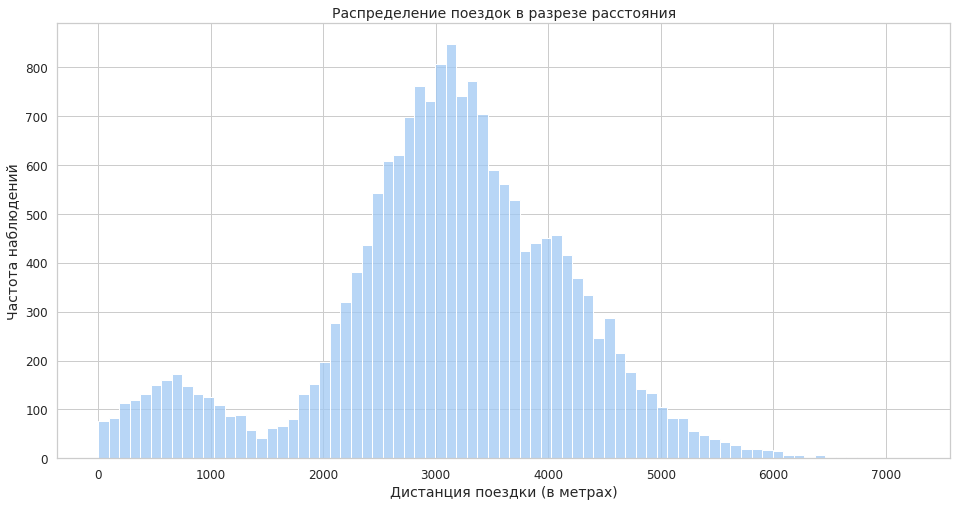

In [28]:
# Создаем стобчатую диаграмму с заданным размером
fig = plt.subplots(figsize=(16, 8))

# столбчатая диаграмма (countplot) возраста пользователей
sns.histplot(data=rides, x='distance')

# Зададим подписи осей и легенды
plt.tick_params(labelsize=12)
plt.title('Распределение поездок в разрезе расстояния', fontsize=14)
plt.ylabel('Частота наблюдений', fontsize=14)
plt.xlabel('Дистанция поездки (в метрах)', fontsize=14)

# Отобразим график
plt.show()

Text(0.5, 0, 'Дистанция поездки (в метрах)')

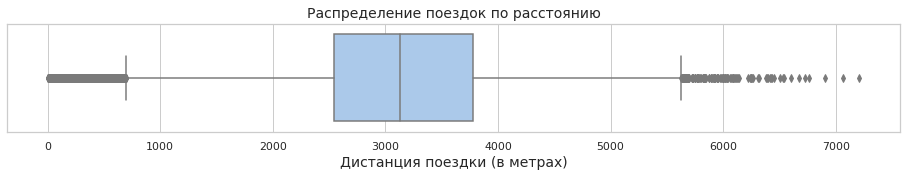

In [29]:
# Создаем boxplot с заданным размером
fig = plt.subplots(figsize=(16, 2))

# boxplot возраста пользователей
sns.boxplot(data=rides, x='distance', orient='h')

plt.title("Распределение поездок по расстоянию", fontsize=14)
plt.xlabel('Дистанция поездки (в метрах)', fontsize=14)

Медианной поездкой с точки зрения дистанции является поездка на чуть более, чем 3000 метров, что близко к заявленному заказчиком оптимальному расстоянию (3130 метров).
Распределение является похожим на нормальное, однако присутствует всплеск поездок с дистанцией около 1 километра, порядка 500-800 метров.
Данные значения могут быть как аномальными, так и указывать на пользователей, предпочитающих поездки на короткое расстояние.

<b> Перейдем к распределению поездок по их продолжительности

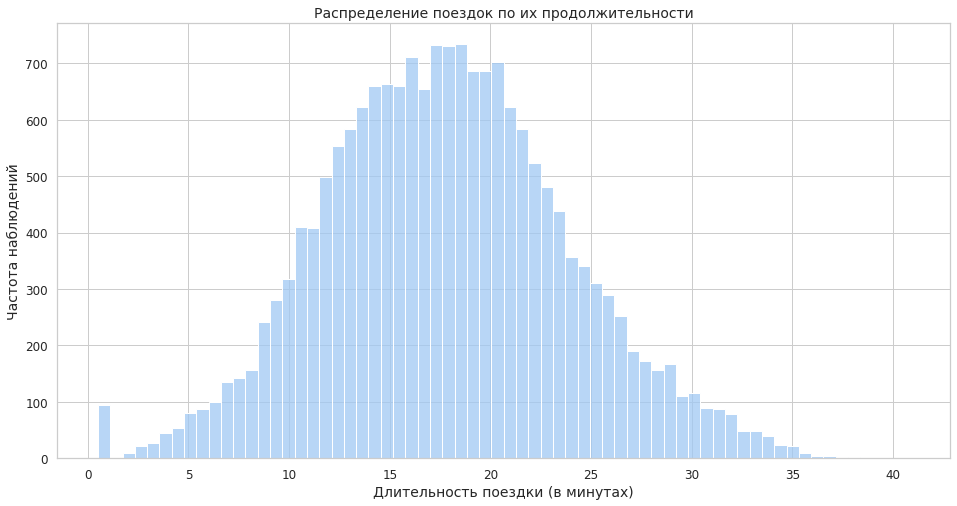

In [30]:
# Создаем стобчатую диаграмму с заданным размером
fig = plt.subplots(figsize=(16, 8))

# столбчатая диаграмма (countplot) возраста пользователей
sns.histplot(data=rides, x='duration')

# Зададим подписи осей и легенды
plt.tick_params(labelsize=12)
plt.title('Распределение поездок по их продолжительности', fontsize=14)
plt.ylabel('Частота наблюдений', fontsize=14)
plt.xlabel('Длительность поездки (в минутах)', fontsize=14)

# Отобразим график
plt.show()

Text(0.5, 0, 'Длительность поездки (в минутах)')

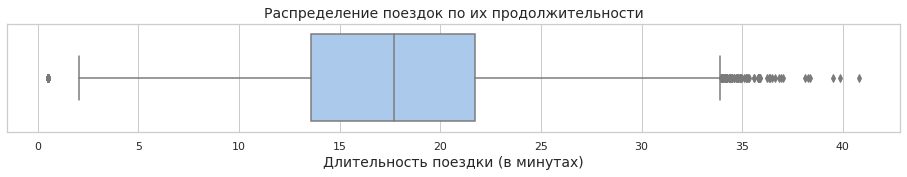

In [31]:
# Создаем boxplot с заданным размером
fig = plt.subplots(figsize=(16, 2))

# boxplot возраста пользователей
sns.boxplot(data=rides, x='duration', orient='h')

plt.title('Распределение поездок по их продолжительности', fontsize=14)
plt.xlabel('Длительность поездки (в минутах)', fontsize=14)

Медианным значением с точки зрения продолжительности является поездка длительностью 17.5 минут. <br> Распределение также похоже на нормальное, однако здесь также присутствует сплеск в районе одной минуты, что может свидетельствовать о технических проблемах при аренде самоката или же о какой-то специфике работы сервиса.

<a id="merge"></a>
# Объединение данных

In [32]:
#объединим таблицы с данными о пользователях, поездках  и подписках в одну таблицу
dfmerged = users.merge(rides, how='inner', on='user_id').merge(subcriptions, how='inner', on='subscription_type')
dfmerged.sample(5)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
396,42,Нина,18,Екатеринбург,ultra,2641.845629,25.851074,2021-07-13,7,6,0,199
8109,818,Антонина,24,Пятигорск,free,4058.926750,19.697700,2021-12-28,12,8,50,0
17320,1483,Роберт,26,Екатеринбург,free,3380.996815,17.244993,2021-11-13,11,8,50,0
4034,435,Игнат,23,Ростов-на-Дону,ultra,3018.519902,12.546300,2021-01-24,1,6,0,199
13390,1204,Марк,23,Ростов-на-Дону,free,2194.993843,12.130741,2021-01-02,1,8,50,0


Проверим не были ли утеряны какие-либо данные при "внутреннем" объединении таблиц:

In [33]:
# посмотрим на размерность таблиц после удаления дубликатов:
display(f'Число строк в таблице users - {users.shape[0]}')
display(f'Число строк в таблице rides - {rides.shape[0]}')
display(f'Число строк в таблице subcriptions - {subcriptions.shape[0]}')

'Число строк в таблице users - 1534'

'Число строк в таблице rides - 18068'

'Число строк в таблице subcriptions - 2'

Учитывая, что мы использовали внутреннее объединение сопоставим число строк в объединенной таблице с таблицей с максимальным числом строк - rides.

In [34]:
display(f'В объединенную таблицу попало {dfmerged.shape[0] / rides.shape[0]:.2%} данных таблицы rides')

'В объединенную таблицу попало 100.00% данных таблицы rides'

На основании таблицы выше создадим еще два датафрейма, которые содержат:
- данные о пользователях без подписки;
- данные о пользователях с подпиской.

In [35]:
dfm_wout_sub = dfmerged[dfmerged['subscription_type'] == 'free']
dfm_with_sub = dfmerged[dfmerged['subscription_type'] == 'ultra']

<b> Дополнительно </b> посмотрим на распределение поездок по месяцам, к примеру, в Москве, чтобы детальнее взглянуть имеется ли просадка использования самокатов в зимние месяцы, т.к. на общем объеме данных существенной тенденции к снижению поездок не было выявлено.

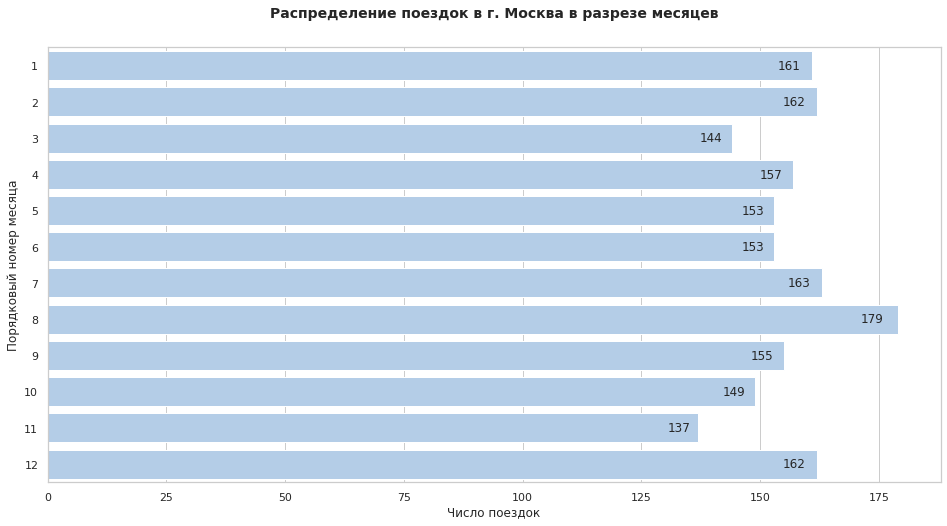

In [38]:
# выберем из объединенной таблицы записи, относящиеся к Москве и посчитаем число поездок в разрезе месяцев
moscow_data = dfmerged[dfmerged.city == 'Москва'].groupby('month')['user_id'].count()

# создаем фигуру и оси для графика
fig, ax = plt.subplots(figsize=(16, 8))

# Стоим горизонтальную столбчатую диаграмму
sns.barplot(x=moscow_data, y=moscow_data.index, ax=ax, color = '#abcdef', orient='h')

# добавим подписи числа поездок в разрезе месяцев
for i, val in enumerate(moscow_data.values):
    ax.text(moscow_data.values[i]*0.97, i, f'{val}', 
                         horizontalalignment='center', 
                         verticalalignment='center', 
                         fontdict={'fontweight':500, 'size': 12})

# Добавим название графика и осей
plt.xlabel('Число поездок')
plt.ylabel('Порядковый номер месяца')
plt.title('Распределение поездок в г. Москва в разрезе месяцев', fontsize=14, fontweight='bold', pad=30)

# Отображаем график
plt.show()

По имеющимся данным можно сделать, что число поездок на самокатах в Москве в декабре-феврале, а также июле фактически идентично, что маловероятно, учитывая климат города.
С нашей точки зрения с большой долей вероятности имеется ошибка в сборе данных и следует сделать запрос инжинеру данных, чтобы уточнить данный нюанс, а также потенциально уточнить у заказчика нет ли какой-то специфики использования самокатов (например, короткие поездки в рамках техобслуживания в закрытом помещении или т.п.).

<b> Детализируем через визуализацию информацию о расстоянии и времени поездок для пользователей с и без подписки.

In [39]:
# зададим словарь цветов из цветовой палитры Set2 seaborn для определения цвета при построении графика ниже
COLORS ={'subscription': {'free': '#fc8d62', 'ultra': '#66c2a5'}}

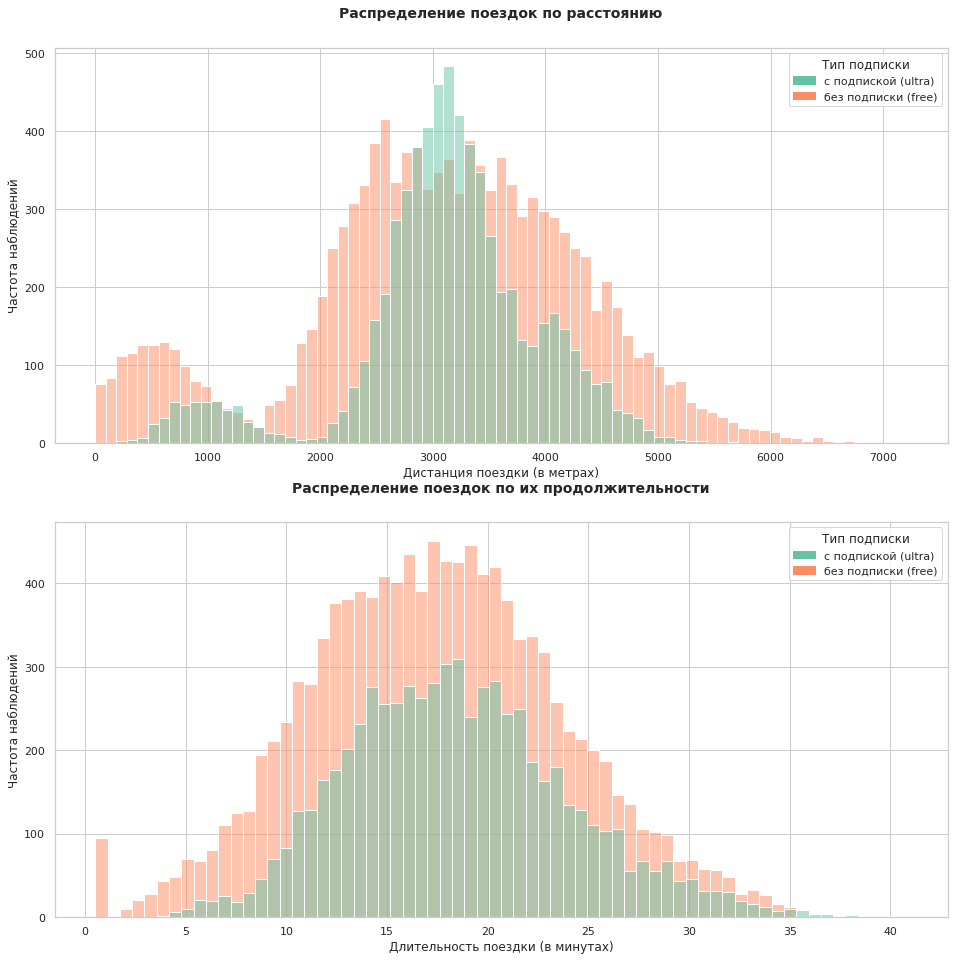

In [40]:
sns.set_theme(style="whitegrid", palette="Set2")

# Создаем фигуру с 2 подграфиками
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=False, figsize=(16, 16))

# Верхний график: гистограмма распределения поездок по расстоянию
sns.histplot(data=dfmerged, x='distance',
             ax=axes[0], alpha=0.5,
             hue='subscription_type')

# Нижний график: гистограмма распределения поездок по длительности
sns.histplot(data=dfmerged, x='duration', 
             ax=axes[1], alpha=0.5,
             hue='subscription_type')

# Устанавливаем названия для осей Y
axes[0].set_ylabel('Частота наблюдений', fontsize=12)
axes[1].set_ylabel('Частота наблюдений', fontsize=12)

# Устанавливаем названия для осей Х
axes[0].set_xlabel('Дистанция поездки (в метрах)', fontsize=12)
axes[1].set_xlabel('Длительность поездки (в минутах)', fontsize=12)

# Устанавливаем заголовок для фигуры
axes[0].set_title('Распределение поездок по расстоянию', fontsize=14, fontweight='bold', pad=30)
axes[1].set_title('Распределение поездок по их продолжительности', fontsize=14, fontweight='bold', pad=30)

# Установим легенды
ultra_patch = mpatches.Patch(color=COLORS['subscription']['ultra'], label='с подпиской (ultra)')
free_patch = mpatches.Patch(color=COLORS['subscription']['free'], label='без подписки (free)')
for i in range(2):
    axes[i-1].legend(title='Тип подписки', handles=[ultra_patch, free_patch])
    
# Отображаем графики
plt.show()

<b> Таким образом, можно сделать следующие выводы: </b>
- расстояние поездки пользователей без подписки имеет больший разброс, чем пользователей с подпиской; <br> 
- количество поездок до 1 км у пользователей без подписки значительно превышает этот же показатель у пользователей с подпиской; <br>
- пользователи без подписки имеют около ста поездок длительностью около минуты, у пользователей с подпиской такие поездки отсутствуют, что вкупе с наличием коротких с точки зрения расстояния поездок может быть связано с какими-то техническими проблемами, учитывая что стоимость старта поездки и 1 минуты движения для пользователей без подписки составляет 50+8=58 рублей (сумма незначительна для фактически любой категории пользователей);<br>
- распределения похожи на нормальное;<br>
- количество поездок на самокатах в Москве в зимние месяцы идентично числу поездок на самокате в Москве в июле, что может свидетельствовать об ошибках в сборе данных и следует сделать запрос инжинеру данных, а также потенциально уточнить у заказчика нет ли какой-то специфики использования самокатов (техобслуживание в закрытом помещении или т.п.).

<a id="revenue"></a>
# Подсчет выручки

Используем метод transform, чтобы добавить в объединенную таблицу столбец с необходимой нам информацией, а после "вытянем" интересующие нас столбцы в отдельный датафрейм.

In [42]:
# рассчитаем суммарное расстояние поездок для каждого пользователя в разрезе месяцев 
dfmerged['distance_sum'] = dfmerged.groupby(['user_id', 'month'])['distance'].transform('sum')

In [43]:
# рассчитаем количество поездок для каждого пользователя в разрезе месяцев 
dfmerged['rides_count'] = dfmerged.groupby(['user_id', 'month'])['user_id'].transform('count')

In [44]:
# рассчитаем суммарную длительность поездок для каждого пользователя в разрезе месяцев 
dfmerged['duration_sum'] = dfmerged.groupby(['user_id', 'month'])['duration'].transform('sum')

In [45]:
# округлим продолжительность поездок в большую сторону с помощью метода 'ceil'
dfmerged['duration_ceil'] = np.ceil(dfmerged['duration'])

In [46]:
# рассчитаем выручку от каждой поездки без учета абонплаты
dfmerged['revenue_wout_subfee'] = dfmerged['duration_ceil'] * dfmerged['minute_price'] + dfmerged['start_ride_price']

In [47]:
# Расчет суммарного дохода для каждого пользователя в каждом месяце
dfmerged['revenue_month'] = (dfmerged.groupby(['user_id', 'month'])['revenue_wout_subfee'].transform('sum') + dfmerged['subscription_fee'])

In [48]:
# создадим требуемый от нас датафрейм с информацией для каждого пользователя в разрезе месяцев
revenue_pivot_table = dfmerged[['user_id', 'month', 'distance_sum', 'duration_sum', 'rides_count', 'revenue_month', 'subscription_type']]

#удалим дубликаты, которые образовались в результате добавления сгруппированных значений в таблицу с несгруппированными данными (изначальный dataframe)
revenue_pivot_table = revenue_pivot_table.drop_duplicates()

In [49]:
display(revenue_pivot_table.sample(10))

,user_id,month,distance_sum,duration_sum,rides_count,revenue_month,subscription_type
3334,360,5,3316.926597,18.474505,1,313.0,ultra
9314,909,10,2251.188391,12.823975,1,154.0,free
12788,1159,12,7239.989298,40.054698,2,428.0,free
13207,1191,1,3973.123284,10.220255,1,138.0,free
8184,825,5,8408.725356,69.642697,4,768.0,free
9836,947,6,4392.101091,19.784202,1,210.0,free
15181,1329,4,12699.938142,84.984517,5,946.0,free
2262,242,5,3869.697168,18.287273,1,313.0,ultra
3049,327,2,3184.118071,27.104708,1,367.0,ultra
3171,343,2,6534.916303,39.638595,2,445.0,ultra


<a id="hypotheses"></a>
# Проверка гипотез

<b> Проверка гипотезы о том, что пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки

<b> Нулевой гипотезой </b> в данном случае будет гипотеза о равенстве математического ожидания времени поездки для пользователей с подпиской и без. <br>
<b> Альтернативной </b> - математическое ожидание времени поездки пользователей с подпиской превышает время поездки для пользователей без подписки.

Выборки независимы, в связи с этим используем метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей (ttest_ind()). <br>
Альтернативная гипотеза звучит как превышение одного среднего над вторым, соответственно, речь идет об односторонней гипотезе.<br>
Параметр equal_var = False, так как дисперсии распределений различаются, исходя из графика распределений построенного нами выше.

In [50]:
print(f'Среднее первой выборки: {dfm_wout_sub.duration.mean():.2f} мин.')
print(f'Среднее второй выборки: {dfm_with_sub.duration.mean():.2f} мин.')

# определим уровень стат. значимости = 5%
alpha = .05

results = st.ttest_ind(dfm_with_sub.duration, dfm_wout_sub.duration, alternative='greater', equal_var=False)

# выведем на экран получившееся p-значение
print(f'p-значение: {results.pvalue}' )

# вывод 
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

Среднее первой выборки: 17.39 мин.
Среднее второй выборки: 18.54 мин.
p-значение: 5.6757813771289775e-37
Отвергаем нулевую гипотезу


Поскольку p-value очень мало и не превышает alpha (в том числе и в случае если бы alpha было бы равно 1%), мы отвергаем нулевую гипотезу о равенстве средних в пользу альтернативной, которая утверждает, что пользователи с подпиской тратят больше времени на поездки пользователей без подписки.

<b> Проверка гипотезы о соотношении среднего расстояния одной поездки в сравнении с заявленным заказчиком оптимальным значением

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

<b> Нулевая гипотеза: </b> математическое ожидание расстояния поездки равно 3130 метрам. <br>
<b> Альтернативная: </b> математическое ожидание расстояния поездки меньше 3130 метров.<br>
Использовать для проверки будем t-test для проверки односторонней гипотезы (ttest_1samp).

In [51]:
print(f'Среднее выборки: {dfm_with_sub.distance.mean():.2f} метров')

# значение оптимального расстояния
value = 3130

# зададим уровень стат.значимости = 5%
alpha = .05

results = st.ttest_1samp(dfm_with_sub.distance, value, alternative='less')

# выведем на экран получившееся p-значение
print(f'p-значение: {results.pvalue}')

# вывод 
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

Среднее выборки: 3115.45 метров
p-значение: 0.08046311521502146
Нет оснований отвергнуть нулевую гипотезу


Значение p-value больше уровня статистической значимости, в связи с этим у нас нет достаточных оснований отвергнуть нулевую гипотезу.

<b> Проверка гипотезы о том, что помесячная выручка от пользователей с подпиской превышает выручку за аналогичный период пользователей без подписки

<b> Нулевая гипотеза: </b> математическое ожидание выручки пользователей с подпиской равно математическому ожиданию выручки пользователей без подписки.<br>
<b> Альтернативная: </b> математическое ожидание выручки пользователей с подпиской превышает (больше) математическое ожидание выручки пользователей без подписки.<br>

Как и в первом случае (по аналогичным причинам) использовать будем метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей (ttest_ind()): выборки независимы. <br> Equal_var=False: дисперсия времени поездок различается у пользователей с и без подписки, кроме того, пользователи с подпиской платят допольнительно за подписку, как следствие, есть основания полагать, что дисперсии распределений выручки различаются.

In [52]:
revenue_ultra = revenue_pivot_table[revenue_pivot_table.subscription_type == 'ultra'].revenue_month
revenue_free = revenue_pivot_table[revenue_pivot_table.subscription_type == 'free'].revenue_month

print(f'Среднее первой выборки: {revenue_ultra.mean():.2f} руб.')
print(f'Среднее второй выборки: {revenue_free.mean():.2f} руб.')

# зададим уровень стат.значимости = 5%
alpha = 0.05

results = st.ttest_ind(revenue_ultra, revenue_free, alternative='greater', equal_var=False)

# выведем на экран получившееся p-значение
print(f'p-значение - {results.pvalue}' )

# вывод 
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

Среднее первой выборки: 362.79 руб.
Среднее второй выборки: 328.64 руб.
p-значение - 8.874140893976874e-40
Отвергаем нулевую гипотезу


Поскольку p-value очень мало и не превышает alpha (в том числе и в случае если бы alpha было бы равно 1%), мы отвергаем нулевую гипотезу о равенстве средних в пользу альтернативной, которая утверждает, что средняя выручка пользователей с подпиской выше, чем у пользователей без подписки.

<a id="conclusions"></a>
# Общие выводы по результатам исследования

- в таблице users присутствовали полные дубликаты, которые были удалены (% таких значений от общего размера таблицы users составлял 1.98%);
- в таблице rides тип данных в столбце с датой был приведен к datetime;
- в нашей выборке не отмечается существенное снижение количества поездок в зимние месяцы года, а количество поездок на самокатах в Москве в зимние месяцы идентично числу поездок на самокате в Москве в июле, что может свидетельствовать об ошибках в сборе данных и следует сделать запрос инжинеру данных, а также потенциально уточнить у заказчика нет ли какой-то специфики использования самокатов (техобслуживание в закрытом помещении или т.п.);
- соотношение числа пользователей с подпиской (ultra) и без (free) представленно в выборке следующим образом: 45% / 55% соответственно;
- минимальный возраст пользователей - 12 лет, максимальный - 43 года, медианный - 25 лет. 50% пользователей это лица от 22 до 28 лет;
- распределение расстояния поездок похоже на нормальное, медианное значение поездки немного превышает 3 км и близко к заявленному заказчиком оптимальному расстоянию в 3130 метров. При этом у нас присутствуют поездки до 1000 метров, что может указывать на ошибки в использовании сервиса (как технические, так и в части удобства использования самокатов) или на группу пользователей, предпочитающих короткие поездки;
- медианная длительность поездки - 17,5 минут, распределение похоже на нормальное, но присутствует всплекс поездок длительностью в 1 минуту, что может свидетельствовать об ошибке использования приложения или же о специфических условиях использования сервиса;
- в результате проверки гипотез можно сформировать следующие выводы:<br>
-- поездки пользователей с подпиской в среднем продолжительнее поездок пользователей без подписки;<br>
-- оснований для опровержения гипотезы о том, что среднее расстояние поездок пользователей с подпиской превышает 3130 метров, у нас недостаточно;<br>
-- выручка пользователей с подпиской в разрезе месяцев выше выручки пользователей без подписки.<br>